In [50]:
import pandas as pd 
from selenobot.utils import DATA_DIR, SCRIPTS_DIR, dataframe_from_fasta
from selenobot.sequences import *
import os
import numpy as np
import subprocess
import time
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings 
import sklearn
import pickle


warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Set the main data directory to be the v3 validation directory. 
# TODO: Should I offload more of the helper functions to a separate file?
organism = 'Btheta'
# organism = 'acidovorax_3H11'
VAL_DIR = os.path.join(DATA_DIR, 'val3') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
predictions_df = pd.read_csv(os.path.join(VAL_DIR, organism, 'predictions.csv')) # , dtype={'id':str}) # Load selenoprotein predictions.
genome_df = dataframe_from_fasta(os.path.join(VAL_DIR, organism, f'genome.fna'), parser=None) 
metadata_df = pd.read_csv(os.path.join(VAL_DIR, organism, 'metadata.csv')) # , dtype={'id':str, 'scaffold_id':str}) 

print('Number of predicted selenoproteins:', np.sum(predictions_df.prediction.values))
print('Average length of predicted selenoproteins:', predictions_df[predictions_df.prediction == 1].seq.apply(len).mean())
print('Average length of predicted non-selenoproteins:', predictions_df[predictions_df.prediction == 0].seq.apply(len).mean()) 

Number of predicted selenoproteins: 16.0
Average length of predicted selenoproteins: 262.875
Average length of predicted non-selenoproteins: 389.43833333333333


## Extending predicted selenoproteins

In [52]:
sec_ids = predictions_df[predictions_df.prediction == 1]['id'].values # Get the IDs of the predicted selenoproteins. 
sec_cseqs = load_cseqs(metadata_df, genome_df=genome_df, use_ids=sec_ids)
# sec_cseqs = load_cseqs(metadata_df, genome_df=genome_df, use_ids=['Ac3H11_329'])
sec_cseqs_extended = [cseq.extend() for cseq in sec_cseqs]

load_cseqs: 100%|██████████| 16/16 [00:00<00:00, 179.00it/s]


In [53]:
# How many of the non-extended proteins already have overlaps?
overlaps_df = []
for cseq in sec_cseqs_extended:
    if len(cseq.overlaps) > 0:
        for seq in cseq.overlaps:
            row = dict()
            row['id'] = cseq.id_
            row['overlaps_with'] = seq.id_
            row['overlap_num'] = len(cseq.overlaps)
            row['overlap_size'] = cseq.overlap(seq)
            row['downstream'] = cseq.is_downstream(seq)
            row['ext_length'] = cseq.ext_length
            overlaps_df.append(row)

overlaps_df = pd.DataFrame(overlaps_df) 
overlaps_df = overlaps_df[overlaps_df.overlap_size > 60]
sec_ids_to_remove = overlaps_df['id'].values 

print(f'Removing {len(sec_ids_to_remove)} predicted selenoproteins from the hits.')
sec_ids_filtered = [id_ for id_ in sec_ids if id_ not in sec_ids_to_remove]

# What if the downstream overlap is a misannotation? It seems like a bad idea to throw out everything with a downstream overlap, 
# just in case it is, in fact, a misannotated selenoprotein. 


Removing 6 predicted selenoproteins from the hits.


In [54]:
# How many overlaps if we extend the proteins?
# It seems not great to include proteins with downstream overlaps in the negative control (as long as we are careful about which
# predicted selenoproteins we analyze). I think that related genes tend to have similar functions, so it is possible that comparing
# the in-protein region with the extended region in some controls is just comparing cofitness between two genes that have a 
# related function. What we really want is to compare the in-gene region with a *non-coding* extended region. 

In [55]:
# https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-9-335


## Analyzing fitness data

There are several requirements that a hit must meet in order to be useful.
1. The sequence must be "extendable," i.e. the hit must not run off the end of the contig.
2. There must have been a transposon insertion in the extended region of the gene. 
3. The gene must create some kind of noticable phenotype when mutated.
4. 
I am thinking about adding an additional requirement, which is that the extended region does not overlap with another gene.

I need to think a little more about if I should adjust the "significant phenotype" standards. In the original paper, they use a minimum t value of 4 and fitness of 0.5, but when I apply this filtering to the selenoprotein hits, I only have a single result. I might try ignoring or loosening the significance constraint when looking at the predicted selenoprotein genes.

### Positive controls

Split the (non-extended) selenoprotein hits in two, and compute cofitness scores for the front half of the gene relative to back half of the gene. 

### Negative controls

For negative controls, extend non-selenoprotein hits to the next stop codon and look at the cofitness score for the extended region versus the main protein. 

In [56]:
fitness_df = pd.read_csv(os.path.join(VAL_DIR, organism, 'fitness.csv')) # , dtype={'id':str, 'scaffold_id':str})
t_values_df = pd.read_csv(os.path.join(VAL_DIR, organism, 't_values.csv')) # , dtype={'id':str})

# # Because of the NaN values, need to manually convert the IDs to strings.
# fitness_df['id'] = fitness_df['id'].apply(lambda id_ : None if pd.isnull(id_) else str(id_).split('.')[0])

In [59]:
# NOTE: I wonder if I should apply any other filters, like maybe number of hits in the extended region. 

negative_control_ids, negative_control_cofitness, negative_control_linregs = [], [], []

# Iterate over all sequences which are not predicted selenoproteins for the negative control. 
pbar = tqdm([id_ for id_ in fitness_df['id'].dropna().unique() if not (id_ in sec_ids)], desc='Filtering ContextSequences...')
for id_ in pbar:
    fbseq = FitnessBrowserSequence(id_, metadata_df=metadata_df, fitness_df=fitness_df, genome_df=genome_df, t_values_df=t_values_df, low_memory=False)

    if (not fbseq.extendable()) or (fbseq.t_values is None):
        continue

    fbseq_extended = fbseq.extend()
    fbseq_extension = fbseq_extended.extension() 

    has_significant_phenotype = fbseq.significant()
    has_hits_in_extended_region = fbseq_extension.hits() > 5
    has_hits_in_main_region = fbseq.hits() > 0
    does_not_overlap = all([(fbseq_extended.is_upstream(seq) is True) or (fbseq_extended.overlap(seq) < 60) for seq in fbseq_extended.overlaps])
    

    if all([has_significant_phenotype, has_hits_in_extended_region, has_hits_in_main_region, does_not_overlap]):
        negative_control_ids.append(id_)
        cofitness, linreg = fbseq.cofitness(fbseq_extension)
        negative_control_linregs.append(linreg)
        negative_control_cofitness.append(cofitness)

    pbar.set_description(f'Filtering ContextSequences... {len(negative_control_ids)} in final list.')

print('Saving negative_control_ids to', os.path.join(VAL_DIR, organism, 'negative_control_ids.csv'))
np.savetxt(os.path.join(VAL_DIR, organism, 'negative_control_ids.csv'), negative_control_ids, delimiter=',', fmt='%s')

print('Saving negative_control_linregs to', os.path.join(VAL_DIR, organism, 'negative_control_linregs.pkl'))
with open(os.path.join(VAL_DIR, organism, 'negative_control_linregs.pkl'), 'wb') as f:
    pickle.dump(negative_control_linregs, f)

print('Saving negative_control_cofitness to', os.path.join(VAL_DIR, organism, 'negative_control_cofitness.csv'))
np.savetxt(os.path.join(VAL_DIR, organism, 'negative_control_cofitness.csv'), negative_control_cofitness, delimiter=',')

Filtering ContextSequences...:   0%|          | 0/4416 [00:00<?, ?it/s]

Filtering ContextSequences... 19 in final list.: 100%|██████████| 4416/4416 [1:34:14<00:00,  1.28s/it]

Saving negative_control_ids to /home/prichter/Documents/selenobot/selenobot/../data/val3/Btheta/negative_control_ids.csv
Saving negative_control_linregs to /home/prichter/Documents/selenobot/selenobot/../data/val3/Btheta/negative_control_linregs.pkl
Saving negative_control_cofitness to /home/prichter/Documents/selenobot/selenobot/../data/val3/Btheta/negative_control_cofitness.csv


In [ ]:
sec_ids, sec_linregs, sec_cofitness = [], [], []

# Iterate over all predicted selenoproteins.
pbar = tqdm(sec_ids_filtered, desc='Filtering ContextSequences...')
for id_ in pbar:
    fbseq = FitnessBrowserSequence(id_, metadata_df=metadata_df, fitness_df=fitness_df, genome_df=genome_df, t_values_df=t_values_df, low_memory=False)

    if (not fbseq.extendable()) or (fbseq.t_values is None):
        continue

    fbseq_extended = fbseq.extend()
    fbseq_extension = fbseq_extended.extension() 

    has_significant_phenotype = fbseq.significant()
    has_hits_in_extended_region = fbseq_extension.hits() > 5
    has_hits_in_main_region = fbseq.hits() > 0

    if has_hits_in_extended_region and has_hits_in_main_region:
        sec_ids.append(id_)
        cofitness, linreg = fbseq.cofitness(fbseq_extension)
        sec_linregs.append(linreg)
        sec_cofitness.append(cofitness)

    pbar.set_description(f'Filtering ContextSequences... {len(sec_ids)} in final list.')

print('Saving sec_ids to', os.path.join(VAL_DIR, organism, 'sec_ids.csv'))
np.savetxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), sec_ids, delimiter=',', fmt='%s')
sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), dtype=str)

print('Saving sec_linregs to', os.path.join(VAL_DIR, organism, 'sec_linregs.pkl'))
with open(os.path.join(VAL_DIR, organism, 'sec_linregs.pkl'), 'wb') as f:
    pickle.dump(sec_linregs, f)

print('Saving sec_cofitness to', os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'))
np.savetxt(os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'), sec_cofitness, delimiter=',')
sec_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'), dtype=float)

Filtering ContextSequences... 4 in final list.: 100%|██████████| 31/31 [00:04<00:00,  7.67it/s]

Saving sec_ids to /home/prichter/Documents/selenobot/selenobot/../data/val3/acidovorax_3H11/sec_ids.csv
Saving sec_linregs to /home/prichter/Documents/selenobot/selenobot/../data/val3/acidovorax_3H11/sec_linregs.pkl
Saving sec_cofitness to /home/prichter/Documents/selenobot/selenobot/../data/val3/acidovorax_3H11/sec_cofitness.csv


In [ ]:
print('Mean negative control cofitness:', np.mean(negative_control_cofitness))
print('Mean predicted selenoprotein cofitness:', np.mean(sec_cofitness))

Mean negative control cofitness: 0.22501869814364475
Mean predicted selenoprotein cofitness: 0.17708479494331528


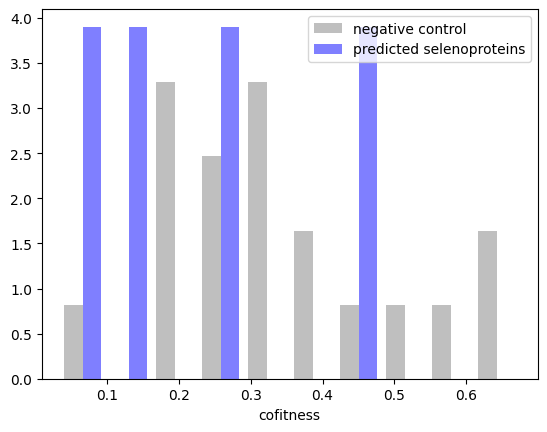

In [60]:
fig, ax = plt.subplots()
vals, _, _ = ax.hist((negative_control_cofitness, sec_cofitness), density=True, color=['gray', 'blue'], alpha=0.5)
ax.legend(['negative control', 'predicted selenoproteins'])
ax.set_xlabel('cofitness')
plt.show()

In [ ]:
negative_control_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'negative_control_cofitness.csv'), dtype=float)
# negative_control_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'negative_control_ids.csv'), dtype=str)
with open(os.path.join(VAL_DIR, organism, 'negative_control_linregs.pkl'), 'rb') as f:
    negative_control_linregs = pickle.load(f)

# positive_control_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'positive_control_cofitness.csv'), dtype=float)
# positive_control_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'positive_control_ids.csv'), dtype=str)
# with open(os.path.join(VAL_DIR, organism, 'positive_control_linregs.pkl'), 'rb') as f:
#     positive_control_linregs = pickle.load(f)

sec_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'), dtype=float)
sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), dtype=str)
# sec_ids = np.array([int(id_) for id_ in sec_ids]) # Only for the organisms for which the IDs are integers. 
with open(os.path.join(VAL_DIR, organism, 'sec_linregs.pkl'), 'rb') as f:
    sec_linregs = pickle.load(f)

In [ ]:
sec_fbseqs = load_fbseqs(metadata_df, fitness_df, t_values_df=t_values_df, genome_df=genome_df, use_ids=sec_ids)
sec_fbseqs_extended = [fbseq.extend() for fbseq in sec_fbseqs]
sec_fbseqs_extension = [fbseq.extension() for fbseq in sec_fbseqs_extended]

load_fbseqs: 100%|██████████| 4/4 [00:00<00:00, 17.61it/s]


In [ ]:
# for fbseq, fbseq_extended in zip(sec_fbseqs, sec_fbseqs_extended):
#     print(fbseq.id_)
#     # print(f'Overlap in non-extended sequence:', fbseq.overlap()) # Confirmed that these were all zero. 
#     print(f'Overlap in extended sequence:', fbseq_extended.overlap())
#     print(f'Extension length:', len(fbseq_extended) - len(fbseq))
#     if fbseq_extended.overlap() > 0:
#         print(f'Overlap with {fbseq.next().id_} {fbseq.next().desc} of length {len(fbseq.next())}')
#     print()

In [ ]:
for id_, cofitness in zip(sec_ids, sec_cofitness):
    print(id_, cofitness)

Ac3H11_45 0.4376463549879728
Ac3H11_2713 0.06619719234485837
Ac3H11_3311 0.05465702995489077
Ac3H11_3538 0.14983860248553924


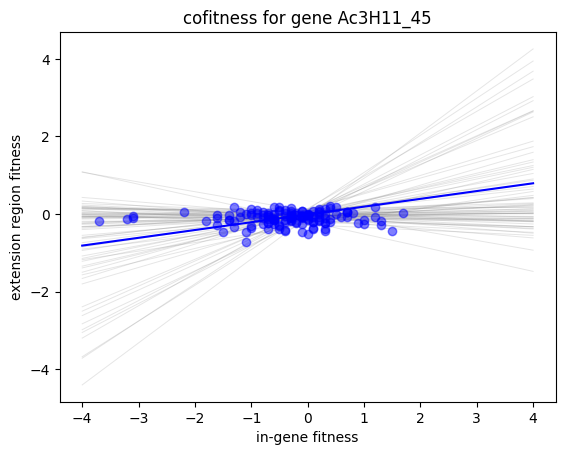

In [ ]:
def plot_cofitness(id_:str):

    fig, ax = plt.subplots()

    x_vals = np.linspace(-4, 4, 50)

    for i, linreg in enumerate(negative_control_linregs):
        # fbseq = FitnessBrowserSequence.from_cseq(negative_control_cseqs[i], fitness_df, t_values_df=t_values_df)
        # fbseq_extension = FitnessBrowserSequence.from_cseq(negative_control_cseqs_extension[i], fitness_df, t_values_df=t_values_df)

        # ax.scatter(fbseq.mean(), fbseq_extension.mean(), color='gray', alpha=0.2, s=2)
        ax.plot(x_vals, x_vals * linreg.slope + linreg.intercept, color='gray', alpha=0.2, lw=0.7, zorder=1)

    # i = np.where(positive_control_ids == id_)[0].item()
    # positive_control_linreg = positive_control_linregs[i]
    # positive_control_cseq_left, positive_control_cseq_right = positive_control_cseqs_split[i]
    # positive_control_fbseq_left = FitnessBrowserSequence.from_cseq(positive_control_cseq_left, fitness_df, t_values_df=t_values_df) 
    # positive_control_fbseq_right = FitnessBrowserSequence.from_cseq(positive_control_cseq_right, fitness_df, t_values_df=t_values_df) 
    # ax.scatter(positive_control_fbseq_left.mean(), positive_control_fbseq_right.mean(), color='black', alpha=0.5)
    # ax.plot(x_vals, x_vals * linreg.slope + linreg.intercept, color='black')
    i = np.where(sec_ids == id_)[0].item()
    sec_linreg = sec_linregs[i]
    sec_fbseq = sec_fbseqs[i]
    sec_fbseq_extension = sec_fbseqs_extension[i]
    ax.scatter(sec_fbseq.mean(), sec_fbseq_extension.mean(), color='blue', alpha=0.5, zorder=3)
    ax.plot(x_vals, x_vals * sec_linreg.slope + sec_linreg.intercept, color='blue', zorder=2)

    ax.set_xlabel('in-gene fitness')
    ax.set_ylabel('extension region fitness')
    ax.set_title(f'cofitness for gene {id_}')


plot_cofitness('Ac3H11_45')

# There do seem to be some outliers in the slopes. I wonder if we should be using "distance from a slope of 1" as
# the metric, as a one-to-one correspondence should probably be the target. Also, there do seem to be 
# outliers in the negative control cofitness values -- perhaps the extension region is overlapping another gene?
# Maybe I should remove these cases as well, and make sure the flagged selenoproteins are also not overlapping.

In [ ]:
def get_p_value(id_):
    '''Compute the significance of the cofitness value considering the distribution of negative control 
    cofitness values. These are correlation coefficients, so no need to use a pivotal test statistic.''' 
    negative_control_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'negative_control_cofitness.csv'), dtype=float)
    sec_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'), dtype=float)
    sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), dtype=str)
    #sec_ids = np.array([int(id_) for id_ in sec_ids]) # Only for the organisms for which the IDs are integers. 

    cofitness = sec_cofitness[sec_ids == id_] # Get the cofitness score for the specified locus. 

    p = np.sum(negative_control_cofitness > cofitness) # Get the number of cofitness values more extreme than that of the predicted selenoprotein. 
    p = p / (len(negative_control_cofitness))
    return p

In [ ]:
# Looking in to some of the outliers in the negative control sequences... Ac3H11_1734

fbseq = FitnessBrowserSequence('Ac3H11_45', metadata_df, fitness_df, genome_df=genome_df, t_values_df=t_values_df, low_memory=False)
print('Initial overlaps:', len(fbseq.overlaps)) # No overlaps initially.
fbseq_extended = fbseq.extend()
print('Size of extension:', fbseq_extended.ext_length)
print('Overlaps after extension:', len(fbseq_extended.overlaps)) # No overlaps initially.
print('Overlaps with:', fbseq_extended.overlaps[0].id_)
print('Size of overlap:', fbseq_extended.overlap(fbseq_extended.overlaps[0]))

Initial overlaps: 1
Size of extension: 111
Overlaps after extension: 1
Overlaps with: Ac3H11_44
Size of overlap: 30


In [ ]:
get_p_value('Ac3H11_45')

0.18571428571428572

In [ ]:
fbseq_45 = FitnessBrowserSequence('Ac3H11_45', metadata_df, fitness_df, genome_df=genome_df, t_values_df=t_values_df, low_memory=False)
fbseq_44 = FitnessBrowserSequence('Ac3H11_44', metadata_df, fitness_df, genome_df=genome_df, t_values_df=t_values_df, low_memory=False)

fbseq_45.cofitness(fbseq_44)

(0.8062105961437273,
 LinregressResult(slope=0.8381500412401482, intercept=0.1252242369835121, rvalue=0.8062105961437273, pvalue=2.9234837557689997e-33, stderr=0.05235798590994237, intercept_stderr=0.036586148038377585))

In [ ]:
# TODO: Try splitting up in-gene observations and seeing if there is any correlation with those.
# TODO: In an attempt to reduce noise, try filtering using t-values. 
# TODO: Some kind of interference score to quantify how much of the downstream region is occupied by another gene.
# TODO: Compare to in-gene fitness values.
# TODO: Color-code experiment observations by category. 
# TODO: Maybe consider using the number of transposon mutations in the downstream region as a way to indicate if a region is useful?
# TODO: Maybe compare stop codon usage among hits to stop codon usage across the genome?

In [ ]:

# positive_control_ids, positive_control_cofitness, positive_control_linregs = [], [], []

# # Iterate over all predicted selenoproteins.
# pbar = tqdm(predictions_df[predictions_df.prediction == 1]['id'].values, desc='Filtering ContextSequences...')
# for id_ in pbar:
#     cseq = ContextSequence(id_, metadata_df=metadata_df, genome_df=genome_df)
#     left_cseq, right_cseq = cseq.split() # Split the gene in two. 
#     # Convert to FitnessBrowserSequence objects to compute cofitness. 
#     left_fbseq = FitnessBrowserSequence.from_cseq(left_cseq, fitness_df, t_values_df=t_values_df)
#     right_fbseq = FitnessBrowserSequence.from_cseq(right_cseq, fitness_df, t_values_df=t_values_df)

#     if (left_fbseq.t_values is not None) and (right_fbseq.t_values is not None):
#         # has_significant_phenotype = fbseq.significance() > 0
#         # print('has_significant_phenotype:', has_significant_phenotype)
#         has_hits_in_both_regions = (right_fbseq.hits() > 0) and (left_fbseq.hits() > 0)

#         if has_hits_in_both_regions:
#             positive_control_ids.append(id_) 
#             cofitness, linreg = left_fbseq.cofitness(right_fbseq)
#             positive_control_cofitness.append(cofitness)
#             positive_control_linregs.append(linreg)

#     pbar.set_description(f'Filtering ContextSequences... {len(positive_control_ids)} in final list.')


# print('Saving positive_control_ids to', os.path.join(VAL_DIR, organism, 'positive_control_ids.csv'))
# np.savetxt(os.path.join(VAL_DIR, organism, 'positive_control_ids.csv'), positive_control_ids, delimiter=',', fmt='%s')
# sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'positive_control_ids.csv'), dtype=str)

# print('Saving positive_control_linregs to', os.path.join(VAL_DIR, organism, 'positive_control_linregs.pkl'))
# with open(os.path.join(VAL_DIR, organism, 'positive_control_linregs.pkl'), 'wb') as f:
#     pickle.dump(positive_control_linregs, f)

# print('Saving positive_control_cofitness to', os.path.join(VAL_DIR, organism, 'positive_control_cofitness.csv'))
# np.savetxt(os.path.join(VAL_DIR, organism, 'positive_control_cofitness.csv'), positive_control_cofitness, delimiter=',')
# sec_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'positive_control_cofitness.csv'), dtype=float)